## Fashion MNIST

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The dataset serves as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.


## Loading the packages

In [1]:
# Import python libraries
import numpy as np
import pandas as pd
import time
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # for evaluating results


# Import standard pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader # lets us load data in batches
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# Import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

#get its version and check available device.
print('Your torch version is {}'.format(torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Your torch version is 1.10.0


device(type='cpu')

## The FashionMNIST dataset

`torchvision` already has the Fashion MNIST dataset. We specify, in the following code, the root directory to store the dataset, snatch the training data, allow it to be downloaded if not present at the local machine, and then apply the `transforms.ToTensor` to turn images into Tensor so we can directly use it with our network. The dataset is stored in the dataset class named `train_set`.

In [ ]:
Transform = transforms.ToTensor() # let us convert Fashion mnist data to tensors
train_data = torchvision.datasets.FashionMNIST(
    root = '../data/',
    train = True,
    transform = Transform, 
    download = True,
)
test_data = torchvision.datasets.FashionMNIST(
    root = '../data/',
    train = False,
    transform = Transform, 
    download = True,
)

train_data.data.size()

torch.Size([60000, 28, 28])

### Visualizing data

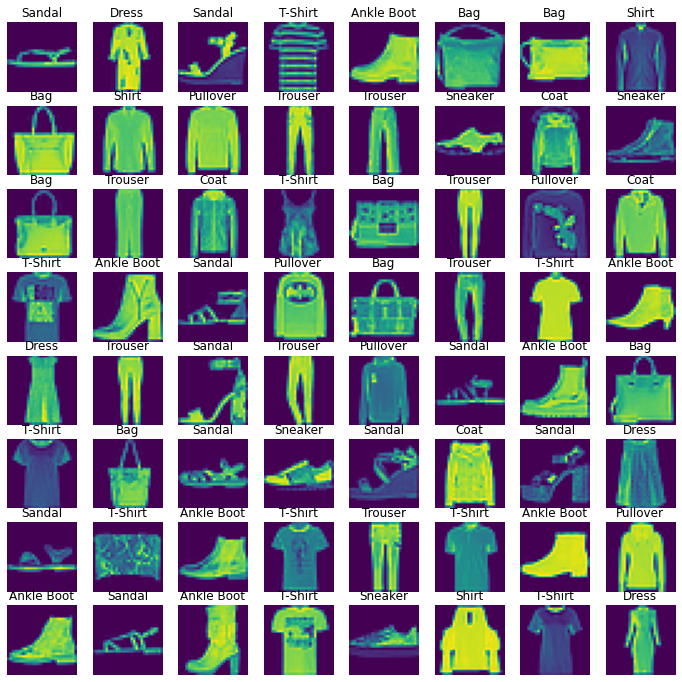

In [3]:
def show_imgs(X):
    
    labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
    
    figure = plt.figure(figsize=(12, 12))
    cols, rows = 8, 8
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(X), size=(1,)).item()
        img, label = X[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze())
    plt.show()
    
show_imgs(train_data)



### Preparing data for training with DataLoaders

In [4]:
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

## CNN with 1 conv layer

We will build a CNN that takes as input tensors of shape *(image_height, image_width, image_channels)*. In this case, inputs are of size (28, 28, 1), which is the format of the FashionMNIST images with only one gray channel.

- The 1st layer is a Conv2D layer for the **convolution** operation that extracts features from the input images by sliding a convolution filter over the input to produce a feature map. Here we choose filters with size 3 x 3. The first layer must also specify the size of the input with `input_shape=(28, 28, 1)`. This layer is followed by an activation layer 'relu'.
- The next layer is a MaxPooling2D layer for the **max-pooling** operation that reduces the dimensionality of each feature, which helps shorten training time and reduce number of parameters. Here we choose the pooling window with size 2 x 2.
- To "fight" overfitting, we may add a Dropout layer as the 3rd layer. **Dropout** is a powerful regularization technique used to reduce overfitting. It forces the model to learn multiple independent representations of the same data by randomly disabling neurons in the learning phase. In this model, we can specify the quantity of neurons that we will randomnly disable, e.g. 20%. The dropout layer does not change the dimension of the data.
- The next step is to feed the last output tensor into one or several Dense layers, otherwise known as **fully-connected** layers. These densely connected classifiers takes as input vectors that are 1D. In our case, the output of the conv-relu-pool-dropout layers is a 3D tensor (13, 13, 32). Thus, we need to flatten the 3D outputs to 1D using a Flatten layer. Finally we can add 2 Dense layers on top.
- As there are 10 classes in FashionMNIST, the final layer has 10 neurons for which we select a softmax activation. **Softmax activation** enables to estimate class posterior probabilities. The winner class is the one with the highest posterior probability.

The `summary()` methods prints out the structure of the network created with the sequential model.

In [5]:
# Build the convolutional neural network, expand on top of nn.Module
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.net =  nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(p=0.2),
        nn.Flatten(),
        nn.Linear(32*14*14,128),
        nn.ReLU(),
        nn.Linear(128,10)
    )

  def forward(self, x):
    #for layer in self.net:
        #x = layer(x)
        #print(x.size())
    x=self.net(x)
    #return F.softmax(x, dim=1)
    return x  # We didn’t add the softmax activation function
                # at the output layer since PyTorch’s CrossEntropy function will take care of that for us.

model = CNN().to(device)

#x = torch.randn(1, 1, 28, 28)
#model(x)

from torchsummary import summary
summary(model, (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
           Dropout-4           [-1, 32, 14, 14]               0
           Flatten-5                 [-1, 6272]               0
            Linear-6                  [-1, 128]         802,944
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 804,554
Trainable params: 804,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.53
Params size (MB): 3.07
Estimated Total Size (MB): 3.60
----------------------------------------------------------------


## Training and evaluating the model

To train our cnn model, first we need to specify the loss function, the optimizer and the metrics we want to track during the training.

- We choose here `nn.CrossEntropyLoss` as the loss function. This loss is used for a multi-class classification problem using categorical labels.
- We chose here the `adam` optimizer. The Adam optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [6]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

### Training
Our model is now ready to be trained. Let's define functions to train() and validate() the model.

In [7]:
def train(epoch, model, data_loader, log_interval=200):
    # Set model to training mode
    model.train()

    total_train_loss = 0
    total_correct = 0
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        data = data.to(device)  # Copy data to GPU if needed
        target = target.to(device)
        optimizer.zero_grad()  # Reset the gradient buffers to zero
        output = model(data)   # Pass data through the network

        loss = criterion(output, target)  # Calculate loss

        loss.backward()  # Backpropagate: Updates the gradients buffer on each parameter
   
        # Update weights: Applies the calcualted gradients to each parameter
        # based on the selected optimizer and its configuration.
        optimizer.step()
        
        total_train_loss += loss.item()
        
        # The maximum value of dimension 1 (class dimension) is the predicted class. Only the class index is
        # relevant, hence the first return value is ignored. as: values, indices = torch.max(output, dim=1)
        _, pred = torch.max(output, dim=1)
        
        # pred == target gives a boolean tensor, where each element represents whether it was correctly predicted.
        # Taking the sum gives the number of correct predictions for this particular batch.
        total_correct += torch.sum(pred == target).item()
                  
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    
    
    # Divided by len(data_loader.dataset) because it's the number of correct predictions in total.
    accuracy_train = total_correct / len(data_loader.dataset)

    # Divided by len(data_loader) because it is the sum across all batches,
    # therefore it's divided by the number of batches.
    # There is a difference in the length of the data_loader compared
    # to the underlying dataset, which the data_loader partitions into batches:
    #   - len(data_loader) == number of batches the dataloader can create
    #   - len(data_loader.dataset) == number of samples in the dataset
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [8]:
# torch.inference_mode() disables certain features that are not required for inference.
@torch.inference_mode() 
def validate(model, data_loader):
    # Put the model in eval mode, which disables training specific behaviour, such as Dropout.
    model.eval() 
 
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).item()
        
        _, pred = torch.max(output, dim=1)
        total_correct += torch.sum(pred == target).item()

        total_preds.append(pred.detach().cpu())

        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

Now we are ready to train our model using the train() function. 

In [9]:
%%time

epochs = 20

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   1%|█▍                                                                                                                                                                          | 2/235 [00:00<00:33,  7.06it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308868


Training Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:22<00:03,  8.96it/s]

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.384665


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.78it/s]



Validation set: Average loss: 0.3826, Accuracy: 8602/10000 (86.02%)



Training Epoch 2:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:27,  8.43it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.380518


Training Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:23<00:03,  8.79it/s]

Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.324771


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.86it/s]



Validation set: Average loss: 0.3426, Accuracy: 8766/10000 (87.66%)



Training Epoch 3:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:27,  8.51it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.337128


Training Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:23<00:03,  8.71it/s]

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.360722


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.79it/s]



Validation set: Average loss: 0.3086, Accuracy: 8897/10000 (88.97%)



Training Epoch 4:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:27,  8.46it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.271225


Training Epoch 4:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:23<00:03,  8.74it/s]

Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.234462


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.81it/s]



Validation set: Average loss: 0.3033, Accuracy: 8895/10000 (88.95%)



Training Epoch 5:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:27,  8.43it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.286553


Training Epoch 5:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:23<00:03,  8.73it/s]

Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.194593


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.72it/s]



Validation set: Average loss: 0.2795, Accuracy: 8963/10000 (89.63%)



Training Epoch 6:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:27,  8.40it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.206590


Training Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:23<00:03,  8.52it/s]

Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.272869


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.68it/s]



Validation set: Average loss: 0.2673, Accuracy: 9037/10000 (90.37%)



Training Epoch 7:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:28,  8.19it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.209823


Training Epoch 7:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:23<00:03,  8.70it/s]

Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.214205


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.33it/s]



Validation set: Average loss: 0.2671, Accuracy: 9063/10000 (90.63%)



Training Epoch 8:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:29,  7.91it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.218663


Training Epoch 8:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:23<00:03,  8.68it/s]

Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.238189


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.70it/s]



Validation set: Average loss: 0.2683, Accuracy: 9012/10000 (90.12%)



Training Epoch 9:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:27,  8.45it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.183293


Training Epoch 9:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:23<00:03,  8.61it/s]

Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.240856


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.70it/s]



Validation set: Average loss: 0.2696, Accuracy: 9011/10000 (90.11%)



Training Epoch 10:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:27,  8.53it/s]

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.202528


Training Epoch 10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:23<00:03,  8.59it/s]

Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.200726


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.06it/s]



Validation set: Average loss: 0.2543, Accuracy: 9093/10000 (90.93%)



Training Epoch 11:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:27,  8.48it/s]

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.181182


Training Epoch 11:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:22<00:03, 10.64it/s]

Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.171924


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.89it/s]



Validation set: Average loss: 0.2441, Accuracy: 9113/10000 (91.13%)



Training Epoch 12:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:27,  8.54it/s]

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.134828


Training Epoch 12:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:23<00:03,  8.76it/s]

Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.145556


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.82it/s]



Validation set: Average loss: 0.2490, Accuracy: 9111/10000 (91.11%)



Training Epoch 13:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:27,  8.61it/s]

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.171435


Training Epoch 13:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:23<00:03,  8.79it/s]

Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.127513


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.42it/s]



Validation set: Average loss: 0.2416, Accuracy: 9165/10000 (91.65%)



Training Epoch 14:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:27,  8.54it/s]

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.197372


Training Epoch 14:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:23<00:03,  8.55it/s]

Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.190668


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.04it/s]



Validation set: Average loss: 0.2330, Accuracy: 9183/10000 (91.83%)



Training Epoch 15:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:26,  8.68it/s]

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.134648


Training Epoch 15:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:23<00:03,  8.55it/s]

Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.111122


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.56it/s]



Validation set: Average loss: 0.2325, Accuracy: 9186/10000 (91.86%)



Training Epoch 16:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:28,  8.11it/s]

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.120410


Training Epoch 16:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:23<00:03,  8.70it/s]

Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.124974


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.75it/s]



Validation set: Average loss: 0.2402, Accuracy: 9188/10000 (91.88%)



Training Epoch 17:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:28,  8.29it/s]

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.132603


Training Epoch 17:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:23<00:03,  8.60it/s]

Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.092170


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.00it/s]



Validation set: Average loss: 0.2368, Accuracy: 9191/10000 (91.91%)



Training Epoch 18:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:27,  8.60it/s]

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.142328


Training Epoch 18:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:23<00:03,  8.63it/s]

Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.124077


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.91it/s]



Validation set: Average loss: 0.2499, Accuracy: 9142/10000 (91.42%)



Training Epoch 19:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:26,  8.79it/s]

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.128263


Training Epoch 19:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:23<00:03,  8.66it/s]

Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.138128


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.78it/s]



Validation set: Average loss: 0.2398, Accuracy: 9197/10000 (91.97%)



Training Epoch 20:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:27,  8.60it/s]

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.126777


Training Epoch 20:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:23<00:03,  8.72it/s]

Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.123437


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.88it/s]


Validation set: Average loss: 0.2580, Accuracy: 9150/10000 (91.50%)

CPU times: user 17min 2s, sys: 1min 25s, total: 18min 28s
Wall time: 9min 43s


## Evaluating the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

#### Loss evolution during training
This can be done first looking at the history of the training.

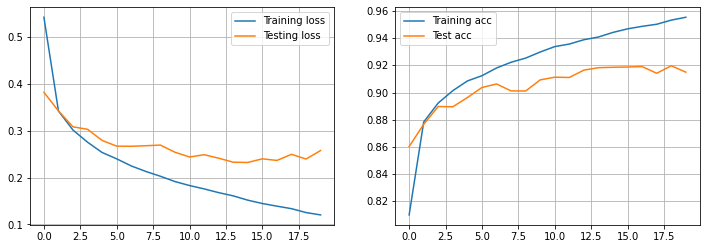

In [10]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

#### Confusion matrix


In [12]:
confusion_matrix(val_result["predictions"], val_result["targets"])

array([[766,   0,  11,   3,   0,   0,  40,   0,   3,   0],
       [  1, 981,   1,   3,   1,   0,   0,   0,   1,   0],
       [ 16,   1, 831,   9,  24,   0,  26,   0,   3,   0],
       [ 27,  11,   8, 931,  26,   0,  27,   0,   6,   0],
       [  6,   4,  71,  20, 906,   0,  65,   0,   1,   0],
       [  1,   0,   0,   0,   0, 988,   0,  14,   2,   6],
       [180,   3,  78,  33,  43,   0, 835,   0,   7,   1],
       [  0,   0,   0,   0,   0,   6,   0, 963,   2,  19],
       [  3,   0,   0,   1,   0,   0,   7,   0, 975,   0],
       [  0,   0,   0,   0,   0,   6,   0,  23,   0, 974]])

### Improving the model

As seen in the previous exercises, we may improve the model performances by stacking CONV-RELU-POOL layers and playing with the different hyper-parameters of the different layers: number of filters, kernel size, etc.

```python
# add blocks such as these one below to increase the depth
nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same'),
nn.ReLU(),
nn.MaxPool2d(kernel_size=2),
nn.Dropout(p=0.2),
```

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by hart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [21]:
train_tfms = transforms.Compose([
                           transforms.RandomAffine(degrees=8, translate=(0.08, 0.08), scale=(0.9, 1.1),
                           shear=(-10, 0)),
                           transforms.RandomCrop(size=(28, 28)),
                           transforms.ToTensor()
                           ])
#valid_tfms = transforms.Compose([transforms.ToTensor()])


In [22]:
train_data_augmented = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=train_tfms, 
    download=True,
)

In [23]:
# augmented data loaders
train_dl = DataLoader(train_data_augmented, batch_size=256, shuffle=True)

Size: torch.Size([1, 28, 28]) Label: 0


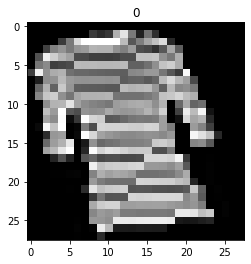

In [24]:
#Plot one train_data_augmented
img, target = train_data_augmented[26]
print('Size:', img.size(), 'Label:', target)
plt.imshow(img.reshape((28,28)), cmap='gray') # to fix the TypeError: Invalid shape (1, 28, 28) for image data
plt.title('%i' % target)
plt.show()

In [25]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.net =  nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p=0.2),
        nn.Flatten(),
        nn.Linear(32*14*14,128),
        nn.ReLU(),
        nn.Linear(128,10)
    )
    
  def forward(self, x):
    x=self.net(x)
    return x

model = CNN().to(device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
           Dropout-4           [-1, 32, 14, 14]               0
           Flatten-5                 [-1, 6272]               0
            Linear-6                  [-1, 128]         802,944
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 804,554
Trainable params: 804,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.53
Params size (MB): 3.07
Estimated Total Size (MB): 3.60
----------------------------------------------------------------


In [26]:
def train(epoch, model, data_loader, log_interval=200):
    model.train()
    total_train_loss = 0
    total_correct = 0
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()  # Reset the gradient buffers to zero
        output = model(data)   # Pass data through the network

        loss = criterion(output, target)  # Calculate loss

        loss.backward()  # Backpropagate: Updates the gradients buffer on each parameter
   
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, pred = torch.max(output, dim=1)
        
        total_correct += torch.sum(pred == target).item()
                  
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    
    
    accuracy_train = total_correct / len(data_loader.dataset)

    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }


@torch.inference_mode() 
def validate(model, data_loader):
    # Put the model in eval mode, which disables training specific behaviour, such as Dropout.
    model.eval() 
 
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).item()
        
        _, pred = torch.max(output, dim=1)
        total_correct += torch.sum(pred == target).item()

        total_preds.append(pred.detach().cpu())

        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

In [27]:
%%time
epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_dl)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   1%|█▍                                                                                                                                                                          | 2/235 [00:00<00:34,  6.67it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295360


Training Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:27<00:04,  7.40it/s]

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.662491


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.75it/s]



Validation set: Average loss: 0.5078, Accuracy: 8090/10000 (80.90%)



Training Epoch 2:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:33,  7.08it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.577136


Training Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:27<00:04,  7.36it/s]

Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.537143


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.76it/s]



Validation set: Average loss: 0.4425, Accuracy: 8403/10000 (84.03%)



Training Epoch 3:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:32,  7.19it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.570539


Training Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:27<00:04,  7.39it/s]

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.492372


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.75it/s]



Validation set: Average loss: 0.4172, Accuracy: 8528/10000 (85.28%)



Training Epoch 4:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:32,  7.13it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.459666


Training Epoch 4:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:27<00:04,  7.29it/s]

Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.410743


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.78it/s]



Validation set: Average loss: 0.3847, Accuracy: 8640/10000 (86.40%)



Training Epoch 5:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:32,  7.12it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.432836


Training Epoch 5:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:27<00:04,  7.26it/s]

Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.483796


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.83it/s]



Validation set: Average loss: 0.3752, Accuracy: 8612/10000 (86.12%)



Training Epoch 6:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:32,  7.20it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.441268


Training Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:27<00:04,  7.26it/s]

Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.341884


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.82it/s]



Validation set: Average loss: 0.3623, Accuracy: 8687/10000 (86.87%)



Training Epoch 7:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:33,  6.95it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.470554


Training Epoch 7:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:27<00:04,  7.24it/s]

Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.459225


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.75it/s]



Validation set: Average loss: 0.3585, Accuracy: 8700/10000 (87.00%)



Training Epoch 8:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:32,  7.24it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.369597


Training Epoch 8:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:27<00:04,  7.26it/s]

Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.394199


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.76it/s]



Validation set: Average loss: 0.3378, Accuracy: 8801/10000 (88.01%)



Training Epoch 9:   0%|▋                                                                                                                                                                           | 1/235 [00:00<00:32,  7.13it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.385758


Training Epoch 9:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 202/235 [00:27<00:04,  7.29it/s]

Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.425517


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.27it/s]



Validation set: Average loss: 0.3291, Accuracy: 8808/10000 (88.08%)



Training Epoch 10:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.27it/s]

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.296457


Training Epoch 10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.26it/s]

Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.444641


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.85it/s]



Validation set: Average loss: 0.3151, Accuracy: 8844/10000 (88.44%)



Training Epoch 11:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.23it/s]

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.340843


Training Epoch 11:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.15it/s]

Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.422871


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.93it/s]



Validation set: Average loss: 0.3134, Accuracy: 8873/10000 (88.73%)



Training Epoch 12:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.22it/s]

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.392438


Training Epoch 12:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.32it/s]

Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.353595


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.94it/s]



Validation set: Average loss: 0.3122, Accuracy: 8860/10000 (88.60%)



Training Epoch 13:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.16it/s]

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.346734


Training Epoch 13:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.31it/s]

Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.423829


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.77it/s]



Validation set: Average loss: 0.3030, Accuracy: 8870/10000 (88.70%)



Training Epoch 14:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.13it/s]

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.303416


Training Epoch 14:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.30it/s]

Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.336549


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.92it/s]



Validation set: Average loss: 0.2980, Accuracy: 8922/10000 (89.22%)



Training Epoch 15:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:31,  7.33it/s]

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.369179


Training Epoch 15:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.34it/s]

Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.282900


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.88it/s]



Validation set: Average loss: 0.2991, Accuracy: 8905/10000 (89.05%)



Training Epoch 16:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.27it/s]

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.317452


Training Epoch 16:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.32it/s]

Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.360892


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.06it/s]



Validation set: Average loss: 0.3042, Accuracy: 8870/10000 (88.70%)



Training Epoch 17:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:31,  7.36it/s]

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.297643


Training Epoch 17:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.25it/s]

Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.374660


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.95it/s]



Validation set: Average loss: 0.2867, Accuracy: 8960/10000 (89.60%)



Training Epoch 18:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.31it/s]

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.306504


Training Epoch 18:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.30it/s]

Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.319954


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.89it/s]



Validation set: Average loss: 0.2894, Accuracy: 8954/10000 (89.54%)



Training Epoch 19:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.29it/s]

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.302639


Training Epoch 19:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.34it/s]

Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.381192


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.01it/s]



Validation set: Average loss: 0.2989, Accuracy: 8904/10000 (89.04%)



Training Epoch 20:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:31,  7.32it/s]

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.444887


Training Epoch 20:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.31it/s]

Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.302649


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.01it/s]



Validation set: Average loss: 0.2852, Accuracy: 8965/10000 (89.65%)



Training Epoch 21:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.31it/s]

Train Epoch: 21 [0/60000 (0%)]	Loss: 0.416519


Training Epoch 21:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.31it/s]

Train Epoch: 21 [51200/60000 (85%)]	Loss: 0.290822


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.89it/s]



Validation set: Average loss: 0.2773, Accuracy: 8991/10000 (89.91%)



Training Epoch 22:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.13it/s]

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.283670


Training Epoch 22:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.32it/s]

Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.382556


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.29it/s]



Validation set: Average loss: 0.2779, Accuracy: 9002/10000 (90.02%)



Training Epoch 23:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.17it/s]

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.329667


Training Epoch 23:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.27it/s]

Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.368743


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.96it/s]



Validation set: Average loss: 0.2679, Accuracy: 9025/10000 (90.25%)



Training Epoch 24:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.28it/s]

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.309298


Training Epoch 24:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:29<00:04,  7.30it/s]

Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.315890


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.84it/s]



Validation set: Average loss: 0.2773, Accuracy: 8979/10000 (89.79%)



Training Epoch 25:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.10it/s]

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.297163


Training Epoch 25:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.18it/s]

Train Epoch: 25 [51200/60000 (85%)]	Loss: 0.271230


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.88it/s]



Validation set: Average loss: 0.2738, Accuracy: 9034/10000 (90.34%)



Training Epoch 26:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.18it/s]

Train Epoch: 26 [0/60000 (0%)]	Loss: 0.292921


Training Epoch 26:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.22it/s]

Train Epoch: 26 [51200/60000 (85%)]	Loss: 0.272994


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.81it/s]



Validation set: Average loss: 0.2711, Accuracy: 9019/10000 (90.19%)



Training Epoch 27:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.18it/s]

Train Epoch: 27 [0/60000 (0%)]	Loss: 0.361897


Training Epoch 27:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.26it/s]

Train Epoch: 27 [51200/60000 (85%)]	Loss: 0.306365


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.98it/s]



Validation set: Average loss: 0.2631, Accuracy: 9038/10000 (90.38%)



Training Epoch 28:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:31,  7.42it/s]

Train Epoch: 28 [0/60000 (0%)]	Loss: 0.318247


Training Epoch 28:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.35it/s]

Train Epoch: 28 [51200/60000 (85%)]	Loss: 0.301007


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.94it/s]



Validation set: Average loss: 0.2714, Accuracy: 9012/10000 (90.12%)



Training Epoch 29:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.29it/s]

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.325826


Training Epoch 29:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.30it/s]

Train Epoch: 29 [51200/60000 (85%)]	Loss: 0.233623


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.00it/s]



Validation set: Average loss: 0.2614, Accuracy: 9046/10000 (90.46%)



Training Epoch 30:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.26it/s]

Train Epoch: 30 [0/60000 (0%)]	Loss: 0.280433


Training Epoch 30:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.29it/s]

Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.332866


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.00it/s]



Validation set: Average loss: 0.2583, Accuracy: 9068/10000 (90.68%)



Training Epoch 31:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.23it/s]

Train Epoch: 31 [0/60000 (0%)]	Loss: 0.278839


Training Epoch 31:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.25it/s]

Train Epoch: 31 [51200/60000 (85%)]	Loss: 0.352337


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.96it/s]



Validation set: Average loss: 0.2569, Accuracy: 9077/10000 (90.77%)



Training Epoch 32:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.26it/s]

Train Epoch: 32 [0/60000 (0%)]	Loss: 0.270258


Training Epoch 32:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.27it/s]

Train Epoch: 32 [51200/60000 (85%)]	Loss: 0.290919


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.91it/s]



Validation set: Average loss: 0.2660, Accuracy: 9048/10000 (90.48%)



Training Epoch 33:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.28it/s]

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.267190


Training Epoch 33:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.27it/s]

Train Epoch: 33 [51200/60000 (85%)]	Loss: 0.283419


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.99it/s]



Validation set: Average loss: 0.2712, Accuracy: 9024/10000 (90.24%)



Training Epoch 34:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.24it/s]

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.296021


Training Epoch 34:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:28<00:04,  7.15it/s]

Train Epoch: 34 [51200/60000 (85%)]	Loss: 0.360817


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.44it/s]



Validation set: Average loss: 0.2602, Accuracy: 9068/10000 (90.68%)



Training Epoch 35:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:34,  6.84it/s]

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.288189


Training Epoch 35:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.31it/s]

Train Epoch: 35 [51200/60000 (85%)]	Loss: 0.284895


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.90it/s]



Validation set: Average loss: 0.2540, Accuracy: 9099/10000 (90.99%)



Training Epoch 36:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.19it/s]

Train Epoch: 36 [0/60000 (0%)]	Loss: 0.286238


Training Epoch 36:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.27it/s]

Train Epoch: 36 [51200/60000 (85%)]	Loss: 0.335939


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.92it/s]



Validation set: Average loss: 0.2523, Accuracy: 9103/10000 (91.03%)



Training Epoch 37:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.15it/s]

Train Epoch: 37 [0/60000 (0%)]	Loss: 0.331636


Training Epoch 37:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.29it/s]

Train Epoch: 37 [51200/60000 (85%)]	Loss: 0.342287


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.90it/s]



Validation set: Average loss: 0.2543, Accuracy: 9100/10000 (91.00%)



Training Epoch 38:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.17it/s]

Train Epoch: 38 [0/60000 (0%)]	Loss: 0.288687


Training Epoch 38:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:28<00:04,  7.13it/s]

Train Epoch: 38 [51200/60000 (85%)]	Loss: 0.295889


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.85it/s]



Validation set: Average loss: 0.2658, Accuracy: 9057/10000 (90.57%)



Training Epoch 39:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.26it/s]

Train Epoch: 39 [0/60000 (0%)]	Loss: 0.205303


Training Epoch 39:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.21it/s]

Train Epoch: 39 [51200/60000 (85%)]	Loss: 0.259476


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.95it/s]



Validation set: Average loss: 0.2483, Accuracy: 9123/10000 (91.23%)



Training Epoch 40:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:31,  7.35it/s]

Train Epoch: 40 [0/60000 (0%)]	Loss: 0.281781


Training Epoch 40:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.29it/s]

Train Epoch: 40 [51200/60000 (85%)]	Loss: 0.285789


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.92it/s]



Validation set: Average loss: 0.2484, Accuracy: 9101/10000 (91.01%)



Training Epoch 41:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:33,  7.08it/s]

Train Epoch: 41 [0/60000 (0%)]	Loss: 0.222565


Training Epoch 41:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.27it/s]

Train Epoch: 41 [51200/60000 (85%)]	Loss: 0.250423


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.97it/s]



Validation set: Average loss: 0.2528, Accuracy: 9108/10000 (91.08%)



Training Epoch 42:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.18it/s]

Train Epoch: 42 [0/60000 (0%)]	Loss: 0.243761


Training Epoch 42:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:28<00:04,  7.26it/s]

Train Epoch: 42 [51200/60000 (85%)]	Loss: 0.352235


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.85it/s]



Validation set: Average loss: 0.2505, Accuracy: 9095/10000 (90.95%)



Training Epoch 43:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:35,  6.67it/s]

Train Epoch: 43 [0/60000 (0%)]	Loss: 0.334959


Training Epoch 43:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:28<00:04,  7.11it/s]

Train Epoch: 43 [51200/60000 (85%)]	Loss: 0.247042


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.79it/s]



Validation set: Average loss: 0.2620, Accuracy: 9061/10000 (90.61%)



Training Epoch 44:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.22it/s]

Train Epoch: 44 [0/60000 (0%)]	Loss: 0.227346


Training Epoch 44:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:28<00:04,  6.77it/s]

Train Epoch: 44 [51200/60000 (85%)]	Loss: 0.354277


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.58it/s]



Validation set: Average loss: 0.2540, Accuracy: 9093/10000 (90.93%)



Training Epoch 45:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:31,  7.50it/s]

Train Epoch: 45 [0/60000 (0%)]	Loss: 0.219616


Training Epoch 45:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.28it/s]

Train Epoch: 45 [51200/60000 (85%)]	Loss: 0.302892


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.29it/s]



Validation set: Average loss: 0.2454, Accuracy: 9136/10000 (91.36%)



Training Epoch 46:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:30,  7.56it/s]

Train Epoch: 46 [0/60000 (0%)]	Loss: 0.280026


Training Epoch 46:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.43it/s]

Train Epoch: 46 [51200/60000 (85%)]	Loss: 0.394303


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.41it/s]



Validation set: Average loss: 0.2582, Accuracy: 9082/10000 (90.82%)



Training Epoch 47:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:31,  7.32it/s]

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.216360


Training Epoch 47:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.28it/s]

Train Epoch: 47 [51200/60000 (85%)]	Loss: 0.282168


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.41it/s]



Validation set: Average loss: 0.2428, Accuracy: 9127/10000 (91.27%)



Training Epoch 48:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:30,  7.61it/s]

Train Epoch: 48 [0/60000 (0%)]	Loss: 0.274031


Training Epoch 48:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.39it/s]

Train Epoch: 48 [51200/60000 (85%)]	Loss: 0.351189


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.47it/s]



Validation set: Average loss: 0.2538, Accuracy: 9100/10000 (91.00%)



Training Epoch 49:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:31,  7.51it/s]

Train Epoch: 49 [0/60000 (0%)]	Loss: 0.317735


Training Epoch 49:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.43it/s]

Train Epoch: 49 [51200/60000 (85%)]	Loss: 0.278237


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.34it/s]



Validation set: Average loss: 0.2515, Accuracy: 9122/10000 (91.22%)



Training Epoch 50:   0%|▋                                                                                                                                                                          | 1/235 [00:00<00:32,  7.30it/s]

Train Epoch: 50 [0/60000 (0%)]	Loss: 0.272097


Training Epoch 50:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 202/235 [00:27<00:04,  7.44it/s]

Train Epoch: 50 [51200/60000 (85%)]	Loss: 0.281032


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.17it/s]


Validation set: Average loss: 0.2432, Accuracy: 9127/10000 (91.27%)

CPU times: user 46min 28s, sys: 3min 21s, total: 49min 49s
Wall time: 28min 37s


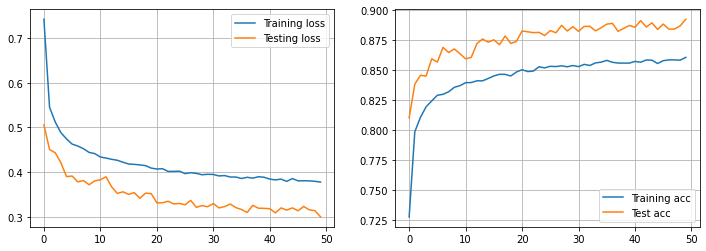

In [20]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()